# Pràctica 4: Similitud de Text Semàntic (STS) per al Català

**Objectiu**: Entrenar i avaluar models de Similitud de Text Semàntic per al català utilitzant diferents tècniques d'embeddings i arquitectures de models.

## Estructura de la Pràctica:
1. **Preparació d'Embeddings** - Carregar i truncar embeddings Word2Vec
2. **Models Baseline** - Similitud cosinus simple
3. **Model 1**: Embeddings Agregats - Vectors de frase concatenats
4. **Model 2**: Seqüència d'Embeddings - Amb mecanisme d'atenció
5. **Experimentació Avançada** - Comparació amb altres embeddings
6. **Anàlisi de Resultats** - Correlació de Pearson i avaluació

In [2]:
# Imports necessaris
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional, Dict, Union
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configuració de GPU (opcional)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU available: []


## 1. Carrega del Dataset STS-ca

In [15]:
from datasets import load_dataset

# Carregar el dataset STS-ca
print("Carregant dataset STS-ca...")
train_data = load_dataset("projecte-aina/sts-ca", split="train")
test_data = load_dataset("projecte-aina/sts-ca", split="test") 
val_data = load_dataset("projecte-aina/sts-ca", split="validation")

# Convertir a DataFrame per facilitar la manipulació
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
val_df = pd.DataFrame(val_data)

print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Label range: {train_df['label'].min():.2f} - {train_df['label'].max():.2f}")

# Mostrar alguns exemples
print("\nExemples del dataset:")
for i in range(3):
    print(f"Frase 1: {train_df.iloc[i]['sentence_1']}")
    print(f"Frase 2: {train_df.iloc[i]['sentence_2']}")
    print(f"Similitud: {train_df.iloc[i]['label']}")
    print("-" * 50)

Carregant dataset STS-ca...
Train samples: 2073
Test samples: 500
Validation samples: 500
Label range: 0.00 - 5.00

Exemples del dataset:
Frase 1: Atorga per primer cop les mencions Encarna Sanahuja a la inclusió de la perspectiva de gènere en docència Universitària
Frase 2: Creen la menció M. Encarna Sanahuja a la inclusió de la perspectiva de gènere en docència universitària
Similitud: 3.5
--------------------------------------------------
Frase 1: Finalment, afegiu-hi els bolets que haureu saltat en una paella amb oli i deixeu-ho coure tot junt durant 5 minuts.
Frase 2: Finalment, poseu-hi les minipastanagues tallades a dauets, els pèsols, rectifiqueu-ho de sal i deixeu-ho coure tot junt durant un parell de minuts més.
Similitud: 1.25
--------------------------------------------------
Frase 1: El TC suspèn el pla d'acció exterior i de relacions amb la UE de la Generalitat
Frase 2: El Constitucional manté la suspensió del pla estratègic d'acció exterior i relacions amb la UE
Similitu

## 2. Carrega i Preparació dels Word Embeddings

In [24]:
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess

# Carregar el model Word2Vec pre-entrenat
WV_MODEL_PATH = '../cc.ca.300.vec'

print("Carregant model Word2Vec...")

kv_model = KeyedVectors.load_word2vec_format(WV_MODEL_PATH, binary=False)
print(f"Model carregat amb èxit. Vocabulari: {len(kv_model.key_to_index)} paraules")
print(f"Dimensió dels vectors: {kv_model.vector_size}")

Carregant model Word2Vec...
Model carregat amb èxit. Vocabulari: 2000000 paraules
Dimensió dels vectors: 300


In [25]:
# Exemple d'ús
test_words = ["casa", "gat", "aigua", "carbassot"]
for word in test_words:
    if word in kv_model:
        print(f"Vector per '{word}': {kv_model[word][:5]}... (dim={kv_model.vector_size})")
    else:
        print(f"Paraula '{word}' no trobada al vocabulari")

Vector per 'casa': [-0.0359 -0.0161 -0.0268  0.0022 -0.0873]... (dim=300)
Vector per 'gat': [ 0.0061  0.0675 -0.0248 -0.0541 -0.0722]... (dim=300)
Vector per 'aigua': [-0.0031  0.0427 -0.0397  0.0366 -0.0551]... (dim=300)
Vector per 'carbassot': [-0.0029 -0.0462 -0.0255 -0.0149 -0.0358]... (dim=300)


In [26]:
# Funció per truncar embeddings a dimensions més petites
def create_truncated_embeddings(kv_model, dimensions: List[int]) -> Dict[int, Dict[str, np.ndarray]]:
    """
    Crea versions truncades dels embeddings amb diferents dimensions
    """
    if kv_model is None:
        return {}
    
    truncated_models = {}
    
    for dim in dimensions:
        print(f"Creant embeddings de {dim} dimensions...")
        truncated_dict = {}
        
        for word in kv_model.key_to_index:
            original_vector = kv_model[word]
            truncated_vector = original_vector[:dim]
            truncated_dict[word] = truncated_vector
            
        truncated_models[dim] = truncated_dict
        print(f"  Completat: {len(truncated_dict)} paraules truncades a {dim}D")
    
    return truncated_models

# Crear versions truncades
dimensions = [50, 100, 150, 300]  # Incloem 300 per consistència
if kv_model is not None:
    truncated_embeddings = create_truncated_embeddings(kv_model, dimensions)
    print(f"\nVersions d'embeddings disponibles: {list(truncated_embeddings.keys())}")
else:
    truncated_embeddings = {}


Creant embeddings de 50 dimensions...
  Completat: 2000000 paraules truncades a 50D
Creant embeddings de 100 dimensions...
  Completat: 2000000 paraules truncades a 100D
Creant embeddings de 150 dimensions...
  Completat: 2000000 paraules truncades a 150D
Creant embeddings de 300 dimensions...
  Completat: 2000000 paraules truncades a 300D

Versions d'embeddings disponibles: [50, 100, 150, 300]


In [27]:
print("Model truncat a 50 dimensions:")
print(truncated_embeddings[50]['casa'])
print("Model truncat a 100 dimensions:")
print(truncated_embeddings[100]['casa'])

Model truncat a 50 dimensions:
[-0.0359 -0.0161 -0.0268  0.0022 -0.0873  0.003   0.0992 -0.0075  0.068
 -0.029   0.0186  0.1191  0.0155  0.0375  0.0158  0.0449 -0.1111  0.0606
  0.022   0.0341  0.0304 -0.0182 -0.024   0.1791 -0.0036  0.0754 -0.1102
  0.0247  0.0228  0.028   0.0685 -0.0146 -0.087  -0.0444  0.0057  0.0172
  0.0022  0.1482  0.029  -0.0377  0.0114 -0.044  -0.0019 -0.0501  0.002
 -0.1389 -0.0044  0.0512 -0.0065  0.0007]
Model truncat a 100 dimensions:
[-0.0359 -0.0161 -0.0268  0.0022 -0.0873  0.003   0.0992 -0.0075  0.068
 -0.029   0.0186  0.1191  0.0155  0.0375  0.0158  0.0449 -0.1111  0.0606
  0.022   0.0341  0.0304 -0.0182 -0.024   0.1791 -0.0036  0.0754 -0.1102
  0.0247  0.0228  0.028   0.0685 -0.0146 -0.087  -0.0444  0.0057  0.0172
  0.0022  0.1482  0.029  -0.0377  0.0114 -0.044  -0.0019 -0.0501  0.002
 -0.1389 -0.0044  0.0512 -0.0065  0.0007  0.0245  0.0052  0.0003  0.0288
  0.0476  0.0015  0.1529 -0.0132  0.025  -0.0274  0.0314  0.0709 -0.0816
 -0.0661  0.0462  0.007

## 3. Funcions d'Utilitat per Preprocessament de Text

In [29]:
def preprocess_sentence(sentence: str) -> List[str]:
    """
    Preprocessa una frase: tokenització simple
    """
    return simple_preprocess(sentence.lower())

def get_sentence_embedding_simple(sentence: str, embeddings_dict: Dict[str, np.ndarray], 
                                vector_size: int) -> np.ndarray:
    """
    Obté l'embedding d'una frase fent la mitjana dels embeddings de les paraules
    """
    words = preprocess_sentence(sentence)
    vectors = []
    
    for word in words:
        if word in embeddings_dict:
            vectors.append(embeddings_dict[word])
    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

def get_sentence_embedding_tfidf(sentence: str, embeddings_dict: Dict[str, np.ndarray], 
                               tfidf_vectorizer: TfidfVectorizer, 
                               feature_names: List[str], vector_size: int) -> np.ndarray:
    """
    Obté l'embedding d'una frase fent la mitjana ponderada amb TF-IDF
    """
    words = preprocess_sentence(sentence)
    
    # Calcular TF-IDF per a la frase
    tfidf_vector = tfidf_vectorizer.transform([' '.join(words)])
    tfidf_scores = tfidf_vector.toarray()[0]
    
    weighted_vectors = []
    weights = []
    
    for word in words:
        if word in embeddings_dict and word in feature_names:
            word_idx = feature_names.index(word)
            weight = tfidf_scores[word_idx]
            if weight > 0:
                weighted_vectors.append(embeddings_dict[word] * weight)
                weights.append(weight)
    
    if weighted_vectors and sum(weights) > 0:
        return np.sum(weighted_vectors, axis=0) / sum(weights)
    else:
        return np.zeros(vector_size)

# Preprocessar totes les frases del dataset
print("Preprocessant frases del dataset...")
all_sentences = (train_df['sentence_1'].tolist() + train_df['sentence_2'].tolist() + 
                test_df['sentence_1'].tolist() + test_df['sentence_2'].tolist() + 
                val_df['sentence_1'].tolist() + val_df['sentence_2'].tolist())

# Crear vocabulari per TF-IDF
all_words = []
for sentence in all_sentences:
    all_words.extend(preprocess_sentence(sentence))

print(f"Total de frases processades: {len(all_sentences)}")
print(f"Vocabulari únic: {len(set(all_words))} paraules")

Preprocessant frases del dataset...
Total de frases processades: 6146
Vocabulari únic: 13125 paraules


## 4. Baseline: Similitud Cosinus

In [40]:
def evaluate_cosine_baseline(df: pd.DataFrame, embeddings_dict: Dict[str, np.ndarray], 
                           vector_size: int, use_tfidf: bool = False, 
                           tfidf_vectorizer=None, feature_names=None) -> Dict[str, float]:
    """
    Avalua el baseline de similitud cosinus
    """
    similarities = []
    true_scores = df['label'].values
    
    for _, row in df.iterrows():
        sent1, sent2 = row['sentence_1'], row['sentence_2']
        
        if use_tfidf and tfidf_vectorizer is not None:
            vec1 = get_sentence_embedding_tfidf(sent1, embeddings_dict, tfidf_vectorizer, 
                                              feature_names, vector_size)
            vec2 = get_sentence_embedding_tfidf(sent2, embeddings_dict, tfidf_vectorizer, 
                                              feature_names, vector_size)
        else:
            vec1 = get_sentence_embedding_simple(sent1, embeddings_dict, vector_size)
            vec2 = get_sentence_embedding_simple(sent2, embeddings_dict, vector_size)
        
        # Calcular similitud cosinus
        if np.all(vec1 == 0) or np.all(vec2 == 0):
            sim = 0.0
        else:
            sim = 1 - cosine(vec1, vec2)
        
        # Escalar de [-1,1] a [0,5] per coincidir amb les etiquetes
        sim_scaled = (sim + 1) * 2.5
        similarities.append(sim_scaled)
    
    # Calcular mètriques
    similarities = np.array(similarities)
    pearson_corr, _ = pearsonr(true_scores, similarities)
    mse = mean_squared_error(true_scores, similarities)
    mae = mean_absolute_error(true_scores, similarities)
    
    return {
        'pearson': pearson_corr,
        'mse': mse,
        'mae': mae,
        'predictions': similarities
    }

# Preparar TF-IDF
if kv_model is not None:
    print("Preparant TF-IDF vectorizer...")
    corpus_for_tfidf = [' '.join(preprocess_sentence(sent)) for sent in all_sentences]
    tfidf_vectorizer = TfidfVectorizer(max_features=10000, lowercase=True)
    tfidf_vectorizer.fit(corpus_for_tfidf)
    feature_names = tfidf_vectorizer.get_feature_names_out().tolist()
    
    print("Avaluant baselines de similitud cosinus...")
    
    # Avaluar per diferents dimensions
    baseline_results = {}
    results_list = []
    for dim in [50, 100, 150, 300]:
        if dim in truncated_embeddings:
            # Mitjana simple
            results_simple = evaluate_cosine_baseline(
                val_df, truncated_embeddings[dim], dim, use_tfidf=False
            )

            # Mitjana ponderada TF-IDF
            results_tfidf = evaluate_cosine_baseline(
                val_df, truncated_embeddings[dim], dim, use_tfidf=True,
                tfidf_vectorizer=tfidf_vectorizer, feature_names=feature_names
            )

            baseline_results[dim] = {
                'simple': results_simple,
                'tfidf': results_tfidf
            }

            results_list.append({
                'Model': 'Baseline Cosinus Simple',
                'Dimensions': f'{dim}D',
                'Pearson': results_simple['pearson'],
                'MSE': results_simple['mse'],
                'MAE': results_simple['mae']
            })
            results_list.append({
                'Model': 'Baseline Cosinus TF-IDF',
                'Dimensions': f'{dim}D',
                'Pearson': results_tfidf['pearson'],
                'MSE': results_tfidf['mse'],
                'MAE': results_tfidf['mae']
            })

    df_baseline_results = pd.DataFrame(results_list)
    display(df_baseline_results)

Preparant TF-IDF vectorizer...
Avaluant baselines de similitud cosinus...


,Model,Dimensions,Pearson,MSE,MAE
0,Baseline Cosinus Simple,50D,0.175156,6.156660,2.335413
1,Baseline Cosinus TF-IDF,50D,0.288679,5.862487,2.279328
2,Baseline Cosinus Simple,100D,0.213043,5.936303,2.290625
3,Baseline Cosinus TF-IDF,100D,0.322226,5.572608,2.219603
4,Baseline Cosinus Simple,150D,0.241811,5.704033,2.242433
5,Baseline Cosinus TF-IDF,150D,0.356393,5.332225,2.169574
6,Baseline Cosinus Simple,300D,0.243586,5.424708,2.181605
7,Baseline Cosinus TF-IDF,300D,0.354348,5.084731,2.115081


## 5. Model 1: Regressió amb Embeddings Agregats

In [41]:
def build_model_aggregated(embedding_dim: int, hidden_size: int = 128, 
                         dropout_rate: float = 0.3) -> tf.keras.Model:
    """
    Construeix el model de regressió amb embeddings agregats
    """
    input_1 = tf.keras.Input(shape=(embedding_dim,), name="input_vector_1")
    input_2 = tf.keras.Input(shape=(embedding_dim,), name="input_vector_2")
    
    # Concatenar els dos vectors
    concatenated = tf.keras.layers.Concatenate(axis=-1)([input_1, input_2])
    
    # Capes de processament
    x = tf.keras.layers.BatchNormalization()(concatenated)
    x = tf.keras.layers.Dense(hidden_size, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(hidden_size // 2, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Capa de sortida (regressió)
    output = tf.keras.layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)
    
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )
    
    return model

def prepare_aggregated_data(df: pd.DataFrame, embeddings_dict: Dict[str, np.ndarray], 
                          vector_size: int, use_tfidf: bool = False,
                          tfidf_vectorizer=None, feature_names=None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepara les dades per al model d'embeddings agregats
    """
    X1, X2, Y = [], [], []
    
    for _, row in df.iterrows():
        sent1, sent2, label = row['sentence_1'], row['sentence_2'], row['label']
        
        if use_tfidf and tfidf_vectorizer is not None:
            vec1 = get_sentence_embedding_tfidf(sent1, embeddings_dict, tfidf_vectorizer, 
                                              feature_names, vector_size)
            vec2 = get_sentence_embedding_tfidf(sent2, embeddings_dict, tfidf_vectorizer, 
                                              feature_names, vector_size)
        else:
            vec1 = get_sentence_embedding_simple(sent1, embeddings_dict, vector_size)
            vec2 = get_sentence_embedding_simple(sent2, embeddings_dict, vector_size)
        
        X1.append(vec1)
        X2.append(vec2)
        Y.append(label)
    
    return np.array(X1), np.array(X2), np.array(Y)

# Entrenar models agregats per diferents dimensions
if kv_model is not None:
    aggregated_results = {}
    
    for dim in [50, 100, 150, 300]:
        if dim in truncated_embeddings:
            print(f"\n=== Entrenant Model Agregat {dim}D ===")
            
            # Preparar dades
            X1_train, X2_train, Y_train = prepare_aggregated_data(
                train_df, truncated_embeddings[dim], dim
            )
            X1_val, X2_val, Y_val = prepare_aggregated_data(
                val_df, truncated_embeddings[dim], dim
            )
            
            print(f"Forma de les dades: X1_train={X1_train.shape}, Y_train={Y_train.shape}")
            
            # Construir i entrenar model
            model = build_model_aggregated(embedding_dim=dim)
            
            # Callbacks
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
            )
            
            reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
            )
            
            # Entrenament
            history = model.fit(
                [X1_train, X2_train], Y_train,
                validation_data=([X1_val, X2_val], Y_val),
                epochs=50,
                batch_size=32,
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )
            
            # Avaluació
            Y_pred = model.predict([X1_val, X2_val]).flatten()
            pearson_corr, _ = pearsonr(Y_val, Y_pred)
            mse = mean_squared_error(Y_val, Y_pred)
            mae = mean_absolute_error(Y_val, Y_pred)
            
            aggregated_results[dim] = {
                'model': model,
                'history': history,
                'pearson': pearson_corr,
                'mse': mse,
                'mae': mae,
                'predictions': Y_pred
            }
            
            print(f"Resultats {dim}D - Pearson: {pearson_corr:.3f}, MSE: {mse:.3f}, MAE: {mae:.3f}")


=== Entrenant Model Agregat 50D ===
Forma de les dades: X1_train=(2073, 50), Y_train=(2073,)
Epoch 1/50


C:\Users\11ser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_vector_1', 'input_vector_2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.3492 - mae: 1.6894 - root_mean_squared_error: 2.0699 - val_loss: 3.9109 - val_mae: 1.8018 - val_root_mean_squared_error: 1.9776 - learning_rate: 0.0010
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8103 - mae: 1.0549 - root_mean_squared_error: 1.3452 - val_loss: 2.1687 - val_mae: 1.2499 - val_root_mean_squared_error: 1.4726 - learning_rate: 0.0010
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5054 - mae: 0.9636 - root_mean_squared_error: 1.2268 - val_loss: 1.1432 - val_mae: 0.8510 - val_root_mean_squared_error: 1.0692 - learning_rate: 0.0010
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2843 - mae: 0.9129 - root_mean_squared_error: 1.1331 - val_loss: 0.7236 - val_mae: 0.6536 - val_root_mean_squared_error: 0.8507 - learning_rate: 0.0010
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2217 - mae: 0.8685 - root_mean_squared_error: 1.1042 - val_loss: 0.7645 - val_mae: 0.6720 - val_root_me

C:\Users\11ser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_vector_1', 'input_vector_2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7237 - mae: 1.5502 - root_mean_squared_error: 1.9192 - val_loss: 3.7897 - val_mae: 1.7681 - val_root_mean_squared_error: 1.9467 - learning_rate: 0.0010
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7647 - mae: 1.0369 - root_mean_squared_error: 1.3278 - val_loss: 2.0882 - val_mae: 1.2210 - val_root_mean_squared_error: 1.4451 - learning_rate: 0.0010
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4581 - mae: 0.9554 - root_mean_squared_error: 1.2074 - val_loss: 1.1936 - val_mae: 0.8765 - val_root_mean_squared_error: 1.0925 - learning_rate: 0.0010
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1595 - mae: 0.8521 - root_mean_squared_error: 1.0765 - val_loss: 0.7802 - val_mae: 0.6953 - val_root_mean_squared_error: 0.8833 - learning_rate: 0.0010
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1060 - mae: 0.8302 - root_mean_squared_error: 1.0516 - val_loss: 0.7392 - val_mae: 0.6753 - val_root_me

C:\Users\11ser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_vector_1', 'input_vector_2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.5142 - mae: 1.7090 - root_mean_squared_error: 2.1023 - val_loss: 3.6844 - val_mae: 1.7381 - val_root_mean_squared_error: 1.9195 - learning_rate: 0.0010
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9256 - mae: 1.0851 - root_mean_squared_error: 1.3869 - val_loss: 1.9245 - val_mae: 1.1555 - val_root_mean_squared_error: 1.3873 - learning_rate: 0.0010
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4303 - mae: 0.9569 - root_mean_squared_error: 1.1944 - val_loss: 0.8802 - val_mae: 0.7419 - val_root_mean_squared_error: 0.9382 - learning_rate: 0.0010
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2791 - mae: 0.8837 - root_mean_squared_error: 1.1305 - val_loss: 0.7177 - val_mae: 0.6523 - val_root_mean_squared_error: 0.8472 - learning_rate: 0.0010
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1715 - mae: 0.8457 - root_mean_squared_error: 1.0822 - val_loss: 0.7824 - val_mae: 0.6844 - val_root_me

C:\Users\11ser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_vector_1', 'input_vector_2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.6688 - mae: 2.1807 - root_mean_squared_error: 2.5501 - val_loss: 3.9253 - val_mae: 1.8057 - val_root_mean_squared_error: 1.9812 - learning_rate: 0.0010
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1420 - mae: 1.1600 - root_mean_squared_error: 1.4623 - val_loss: 1.6454 - val_mae: 1.0545 - val_root_mean_squared_error: 1.2827 - learning_rate: 0.0010
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4591 - mae: 0.9612 - root_mean_squared_error: 1.2077 - val_loss: 0.8593 - val_mae: 0.7345 - val_root_mean_squared_error: 0.9270 - learning_rate: 0.0010
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3432 - mae: 0.9215 - root_mean_squared_error: 1.1588 - val_loss: 0.7168 - val_mae: 0.6457 - val_root_mean_squared_error: 0.8466 - learning_rate: 0.0010
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1859 - mae: 0.8510 - root_mean_squared_error: 1.0888 - val_loss: 0.7588 - val_mae: 0.6649 - val_root_me

## 6. Model 2: Seqüència d'Embeddings amb Atenció

In [42]:
class SimpleAttention(tf.keras.layers.Layer):
    """
    Capa d'atenció simple per agregar seqüències d'embeddings
    """
    def __init__(self, units: int = 128, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.units = units
        self.W1 = tf.keras.layers.Dense(units, activation='tanh', name="attention_transform")
        self.W2 = tf.keras.layers.Dense(1, name="attention_scorer")
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.supports_masking = True

    def __call__(self, inputs, mask=None):
        # inputs shape: (batch_size, sequence_length, embedding_dim)
        
        # Calcular scores d'atenció
        ui = self.W1(inputs)  # (batch_size, sequence_length, units)
        ui = self.dropout(ui)
        scores = self.W2(ui)  # (batch_size, sequence_length, 1)
        scores = tf.squeeze(scores, axis=-1)  # (batch_size, sequence_length)
        
        # Aplicar màscara si existeix
        if mask is not None:
            mask = tf.cast(mask, dtype=tf.float32)
            scores = tf.where(mask, scores, tf.fill(tf.shape(scores), -1e9))
        
        # Calcular pesos d'atenció
        alpha = tf.nn.softmax(scores, axis=-1)  # (batch_size, sequence_length)
        alpha = tf.expand_dims(alpha, axis=-1)  # (batch_size, sequence_length, 1)
        
        # Vector de context com a suma ponderada
        context_vector = tf.reduce_sum(alpha * inputs, axis=1)  # (batch_size, embedding_dim)
        
        return context_vector

    def get_config(self):
        config = super().get_config()
        config.update({'units': self.units})
        return config

def build_model_sequence(vocab_size: int, embedding_dim: int, sequence_length: int = 32,
                               attention_units: int = 64, pretrained_weights: Optional[np.ndarray] = None,
                               trainable_embeddings: bool = False) -> tf.keras.Model:
    """
    Versió simplificada del model de seqüències (sense operacions problemàtiques)
    """
    input_1 = tf.keras.Input(shape=(sequence_length,), dtype=tf.int32, name="input_sequence_1")
    input_2 = tf.keras.Input(shape=(sequence_length,), dtype=tf.int32, name="input_sequence_2")
    
    # Capa d'embedding
    if pretrained_weights is not None:
        embedding_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=sequence_length,
            weights=[pretrained_weights],
            trainable=trainable_embeddings,
            mask_zero=True,
            name="embedding"
        )
    else:
        embedding_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=sequence_length,
            trainable=True,
            mask_zero=True,
            name="embedding"
        )
    
    # Aplicar embedding
    embedded_1 = embedding_layer(input_1)
    embedded_2 = embedding_layer(input_2)
    
    # Usar GlobalAveragePooling en lloc d'atenció
    pooling_layer = tf.keras.layers.GlobalAveragePooling1D(name="global_avg_pooling")
    
    pooled_1 = pooling_layer(embedded_1)
    pooled_2 = pooling_layer(embedded_2)
    
    # Concatenar i processar
    concatenated = tf.keras.layers.Concatenate(axis=-1)([pooled_1, pooled_2])
    
    # Capes denses
    x = tf.keras.layers.BatchNormalization()(concatenated)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # Sortida
    output = tf.keras.layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)
    
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
    )
    
    return model

In [43]:
from typing import List, Dict, Tuple
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

# Preparació de dades per al model de seqüències
def create_vocabulary_mapping(sentences: List[str], max_vocab_size: int = 10000) -> Tuple[Dict[str, int], Dict[int, str]]:
    """
    Crea un mapatge de vocabulari paraula->índex i índex->paraula
    """
    word_counts = {}
    for sentence in sentences:
        words = preprocess_sentence(sentence)
        for word in words:
            word_counts[word] = word_counts.get(word, 0) + 1
    
    # Ordenar per freqüència i prendre les més comunes
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Reservar índexs especials: 0=PAD, 1=UNK
    word_to_idx = {"<PAD>": 0, "<UNK>": 1}
    idx_to_word = {0: "<PAD>", 1: "<UNK>"}
    
    for word, count in sorted_words[:max_vocab_size-2]:  # -2 per PAD i UNK
        idx = len(word_to_idx)
        word_to_idx[word] = idx
        idx_to_word[idx] = word
    
    return word_to_idx, idx_to_word

def sentence_to_sequence(sentence: str, word_to_idx: Dict[str, int], 
                        max_length: int = 32) -> np.ndarray:
    """
    Converteix una frase a seqüència d'índexs
    """
    words = preprocess_sentence(sentence)
    sequence = []
    
    for word in words:
        if word in word_to_idx:
            sequence.append(word_to_idx[word])
        else:
            sequence.append(word_to_idx["<UNK>"])
    
    # Padding o truncament
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    else:
        sequence.extend([word_to_idx["<PAD>"]] * (max_length - len(sequence)))
    
    return np.array(sequence)

def create_pretrained_embedding_matrix(word_to_idx: Dict[str, int], 
                                     embeddings_dict: Dict[str, np.ndarray],
                                     embedding_dim: int) -> np.ndarray:
    """
    Crea una matriu d'embeddings pre-entrenats
    """
    vocab_size = len(word_to_idx)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, idx in word_to_idx.items():
        if word in embeddings_dict:
            embedding_matrix[idx] = embeddings_dict[word]
        # Les paraules no trobades mantenen vectors zero
    
    return embedding_matrix

if kv_model is not None:
    print("Preparant dades per al model de seqüències...")
    
    # Crear vocabulari
    word_to_idx, idx_to_word = create_vocabulary_mapping(all_sentences, max_vocab_size=10000)
    vocab_size = len(word_to_idx)
    sequence_length = 32
    
    print(f"Vocabulari creat: {vocab_size} paraules")
    print(f"Longitud de seqüència: {sequence_length}")
    
    # Convertir frases a seqüències per al model de 150D (exemple)
    embedding_dim = 150
    
    if embedding_dim in truncated_embeddings:
        print(f"Creant model de seqüències amb embeddings de {embedding_dim}D...")
        
        # Preparar matriu d'embeddings pre-entrenats
        pretrained_matrix = create_pretrained_embedding_matrix(
            word_to_idx, truncated_embeddings[embedding_dim], embedding_dim
        )
        
        # Convertir dades
        def prepare_sequence_data(df):
            X1_seq, X2_seq, Y_seq = [], [], []
            for _, row in df.iterrows():
                seq1 = sentence_to_sequence(row['sentence_1'], word_to_idx, sequence_length)
                seq2 = sentence_to_sequence(row['sentence_2'], word_to_idx, sequence_length)
                X1_seq.append(seq1)
                X2_seq.append(seq2)
                Y_seq.append(row['label'])
            return np.array(X1_seq), np.array(X2_seq), np.array(Y_seq)
        
        X1_train_seq, X2_train_seq, Y_train_seq = prepare_sequence_data(train_df)
        X1_val_seq, X2_val_seq, Y_val_seq = prepare_sequence_data(val_df)
        
        print(f"Dades de seqüència preparades: {X1_train_seq.shape}")
        
        # Entrenar model amb embeddings pre-entrenats (no trainable)
        print("\nEntrenant model amb embeddings pre-entrenats (frozen)...")
        model_seq_frozen = build_model_sequence(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            sequence_length=sequence_length,
            pretrained_weights=pretrained_matrix,
            trainable_embeddings=False
        )
        
        # Entrenament
        history_frozen = model_seq_frozen.fit(
            [X1_train_seq, X2_train_seq], Y_train_seq,
            validation_data=([X1_val_seq, X2_val_seq], Y_val_seq),
            epochs=30,
            batch_size=32,
            verbose=1
        )
        
        # Avaluació
        Y_pred_frozen = model_seq_frozen.predict([X1_val_seq, X2_val_seq]).flatten()
        pearson_frozen, _ = pearsonr(Y_val_seq, Y_pred_frozen)
        mse_frozen = mean_squared_error(Y_val_seq, Y_pred_frozen)
        
        print(f"Model amb embeddings frozen - Pearson: {pearson_frozen:.3f}, MSE: {mse_frozen:.3f}")
        
        # Entrenar model amb embeddings fine-tunejables
        print("\nEntrenant model amb embeddings fine-tunejables...")
        model_seq_trainable = build_model_sequence(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            sequence_length=sequence_length,
            pretrained_weights=pretrained_matrix,
            trainable_embeddings=True
        )
        
        history_trainable = model_seq_trainable.fit(
            [X1_train_seq, X2_train_seq], Y_train_seq,
            validation_data=([X1_val_seq, X2_val_seq], Y_val_seq),
            epochs=30,
            batch_size=32,
            verbose=1
        )
        
        Y_pred_trainable = model_seq_trainable.predict([X1_val_seq, X2_val_seq]).flatten()
        pearson_trainable, _ = pearsonr(Y_val_seq, Y_pred_trainable)
        mse_trainable = mean_squared_error(Y_val_seq, Y_pred_trainable)
        
        print(f"Model amb embeddings trainable - Pearson: {pearson_trainable:.3f}, MSE: {mse_trainable:.3f}")

Preparant dades per al model de seqüències...
Vocabulari creat: 10000 paraules
Longitud de seqüència: 32
Creant model de seqüències amb embeddings de 150D...
Dades de seqüència preparades: (2073, 32)

Entrenant model amb embeddings pre-entrenats (frozen)...
Epoch 1/30


C:\Users\11ser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
C:\Users\11ser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_sequence_1', 'input_sequence_2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.0927 - mae: 1.1414 - val_loss: 5.2821 - val_mae: 2.1420
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0700 - mae: 0.8289 - val_loss: 4.0810 - val_mae: 1.8477
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9861 - mae: 0.7853 - val_loss: 3.4600 - val_mae: 1.6765
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9028 - mae: 0.7428 - val_loss: 2.7949 - val_mae: 1.4720
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8481 - mae: 0.7253 - val_loss: 2.4503 - val_mae: 1.3568
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7740 - mae: 0.6860 - val_loss: 2.0480 - val_mae: 1.2095
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7178 - mae: 0.6645 - val_loss: 1.7966 - val_mae: 1.1127
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6208 - mae: 0.6171 - val_loss: 1.4460 - val_mae: 0.9713
Epoch 9/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6054 - mae: 0.6135 - va

C:\Users\11ser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
C:\Users\11ser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_sequence_1', 'input_sequence_2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.0327 - mae: 1.3690 - val_loss: 5.2806 - val_mae: 2.1412
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8593 - mae: 0.7267 - val_loss: 4.7284 - val_mae: 2.0132
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5658 - mae: 0.5870 - val_loss: 4.4531 - val_mae: 1.9452
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4742 - mae: 0.5352 - val_loss: 3.9089 - val_mae: 1.8029
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4217 - mae: 0.5065 - val_loss: 3.5768 - val_mae: 1.7112
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3685 - mae: 0.4649 - val_loss: 3.2097 - val_mae: 1.6032
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3488 - mae: 0.4522 - val_loss: 3.0406 - val_mae: 1.5515
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3335 - mae: 0.4441 - val_loss: 2.2732 - val_mae: 1.2951
Epoch 9/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2991 - mae: 0.4189 - v

## 7. Anàlisi Comparativa i Visualització de Resultats

In [44]:
# Crear un resum de tots els resultats
if kv_model is not None:
    print("=== RESUM DE RESULTATS ===\n")
    
    results_summary = []
    
    # Baselines cosinus
    print("BASELINES COSINUS:")
    for dim in [50, 100, 150, 300]:
        if dim in baseline_results:
            simple_r = baseline_results[dim]['simple']['pearson']
            tfidf_r = baseline_results[dim]['tfidf']['pearson']
            results_summary.append(['Baseline Cosinus Simple', f'{dim}D', simple_r, baseline_results[dim]['simple']['mse'], baseline_results[dim]['simple']['mae']])
            results_summary.append(['Baseline Cosinus TF-IDF', f'{dim}D', tfidf_r, baseline_results[dim]['tfidf']['mse'], baseline_results[dim]['tfidf']['mae']])
            print(f"  {dim}D - Simple: {simple_r:.3f}, TF-IDF: {tfidf_r:.3f}")
    
    # Models de regressió agregats
    print("\nMODELS DE REGRESSIÓ AGREGATS:")
    for dim in [50, 100, 150, 300]:
        if dim in aggregated_results:
            pearson_r = aggregated_results[dim]['pearson']
            mse_r = aggregated_results[dim]['mse']
            mae_r = aggregated_results[dim]['mae']
            results_summary.append(['Model Agregat', f'{dim}D', pearson_r, mse_r, mae_r])
            print(f"  {dim}D - Pearson: {pearson_r:.3f}, MSE: {mse_r:.3f}")
    
    # Models de seqüència
    if 'pearson_frozen' in locals():
        print(f"\nMODELS DE SEQÜÈNCIA ({embedding_dim}D):")
        print(f"  Embeddings Frozen - Pearson: {pearson_frozen:.3f}, MSE: {mse_frozen:.3f}")
        print(f"  Embeddings Trainable - Pearson: {pearson_trainable:.3f}, MSE: {mse_trainable:.3f}")
        results_summary.append(['Model Seqüència (Frozen)', f'{embedding_dim}D', pearson_frozen, mse_frozen, None])
        results_summary.append(['Model Seqüència (Trainable)', f'{embedding_dim}D', pearson_trainable, mse_trainable, None])
    
    # Crear DataFrame per visualització
    df_results = pd.DataFrame(results_summary, columns=['Model', 'Dimensions', 'Pearson', 'MSE', 'MAE'])
    
    print("\n=== TAULA DE RESULTATS ===")
    display(df_results)

=== RESUM DE RESULTATS ===

BASELINES COSINUS:
  50D - Simple: 0.175, TF-IDF: 0.289
  100D - Simple: 0.213, TF-IDF: 0.322
  150D - Simple: 0.242, TF-IDF: 0.356
  300D - Simple: 0.244, TF-IDF: 0.354

MODELS DE REGRESSIÓ AGREGATS:
  50D - Pearson: 0.123, MSE: 0.724
  100D - Pearson: 0.198, MSE: 0.705
  150D - Pearson: 0.129, MSE: 0.718
  300D - Pearson: 0.173, MSE: 0.717

MODELS DE SEQÜÈNCIA (150D):
  Embeddings Frozen - Pearson: 0.233, MSE: 0.846
  Embeddings Trainable - Pearson: 0.227, MSE: 0.907

=== TAULA DE RESULTATS ===


,Model,Dimensions,Pearson,MSE,MAE
0,Baseline Cosinus Simple,50D,0.175156,6.156660,2.335413
1,Baseline Cosinus TF-IDF,50D,0.288679,5.862487,2.279328
2,Baseline Cosinus Simple,100D,0.213043,5.936303,2.290625
3,Baseline Cosinus TF-IDF,100D,0.322226,5.572608,2.219603
4,Baseline Cosinus Simple,150D,0.241811,5.704033,2.242433
5,Baseline Cosinus TF-IDF,150D,0.356393,5.332225,2.169574
6,Baseline Cosinus Simple,300D,0.243586,5.424708,2.181605
7,Baseline Cosinus TF-IDF,300D,0.354348,5.084731,2.115081
8,Model Agregat,50D,0.122906,0.723610,0.653587
9,Model Agregat,100D,0.198141,0.705497,0.654154


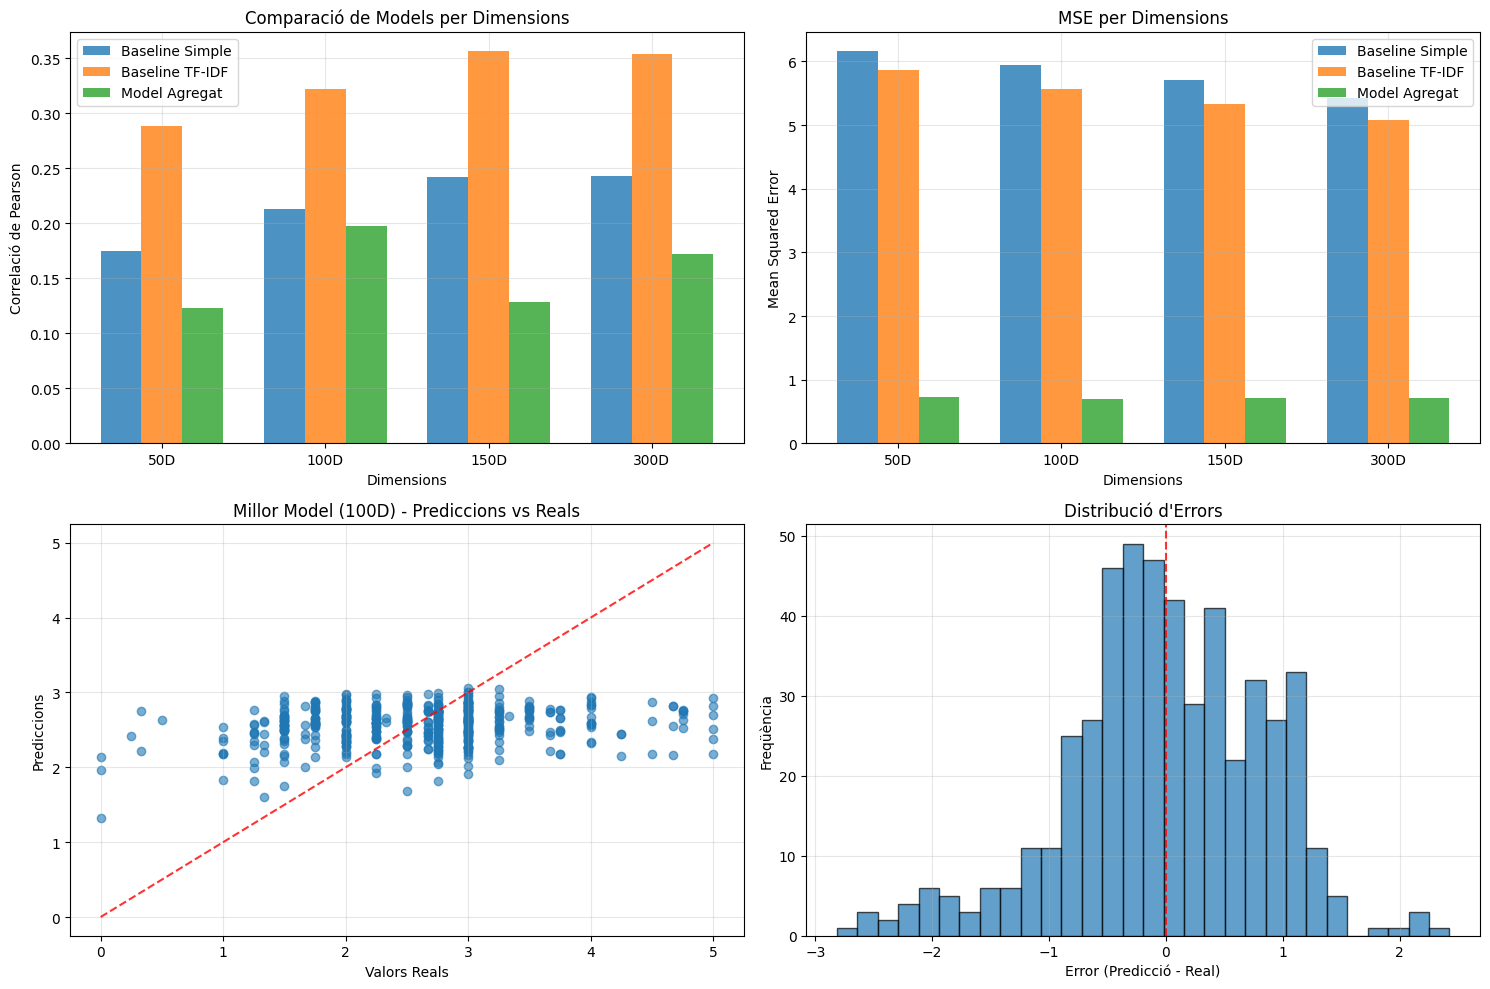

In [45]:
# Visualitzacions
if kv_model is not None and len(results_summary) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Gràfic 1: Comparació de Pearson per dimensions
    baseline_dims = [50, 100, 150, 300]
    baseline_simple = [baseline_results[d]['simple']['pearson'] for d in baseline_dims if d in baseline_results]
    baseline_tfidf = [baseline_results[d]['tfidf']['pearson'] for d in baseline_dims if d in baseline_results]
    aggregated_pearson = [aggregated_results[d]['pearson'] for d in baseline_dims if d in aggregated_results]
    
    x = np.arange(len(baseline_dims))
    width = 0.25
    
    axes[0,0].bar(x - width, baseline_simple, width, label='Baseline Simple', alpha=0.8)
    axes[0,0].bar(x, baseline_tfidf, width, label='Baseline TF-IDF', alpha=0.8)
    axes[0,0].bar(x + width, aggregated_pearson, width, label='Model Agregat', alpha=0.8)
    
    axes[0,0].set_xlabel('Dimensions')
    axes[0,0].set_ylabel('Correlació de Pearson')
    axes[0,0].set_title('Comparació de Models per Dimensions')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels([f'{d}D' for d in baseline_dims])
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Gràfic 2: MSE per dimensions
    baseline_mse_simple = [baseline_results[d]['simple']['mse'] for d in baseline_dims if d in baseline_results]
    baseline_mse_tfidf = [baseline_results[d]['tfidf']['mse'] for d in baseline_dims if d in baseline_results]
    aggregated_mse = [aggregated_results[d]['mse'] for d in baseline_dims if d in aggregated_results]
    
    axes[0,1].bar(x - width, baseline_mse_simple, width, label='Baseline Simple', alpha=0.8)
    axes[0,1].bar(x, baseline_mse_tfidf, width, label='Baseline TF-IDF', alpha=0.8)
    axes[0,1].bar(x + width, aggregated_mse, width, label='Model Agregat', alpha=0.8)
    
    axes[0,1].set_xlabel('Dimensions')
    axes[0,1].set_ylabel('Mean Squared Error')
    axes[0,1].set_title('MSE per Dimensions')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([f'{d}D' for d in baseline_dims])
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Gràfic 3: Prediccions vs Valors Reals (millor model)
    best_model_key = max(aggregated_results.keys(), key=lambda k: aggregated_results[k]['pearson'])
    best_predictions = aggregated_results[best_model_key]['predictions']
    
    axes[1,0].scatter(Y_val_seq if 'Y_val_seq' in locals() else val_df['label'].values, 
                     best_predictions, alpha=0.6)
    axes[1,0].plot([0, 5], [0, 5], 'r--', alpha=0.8)
    axes[1,0].set_xlabel('Valors Reals')
    axes[1,0].set_ylabel('Prediccions')
    axes[1,0].set_title(f'Millor Model ({best_model_key}D) - Prediccions vs Reals')
    axes[1,0].grid(True, alpha=0.3)
    
    # Gràfic 4: Distribució d'errors
    errors = best_predictions - (Y_val_seq if 'Y_val_seq' in locals() else val_df['label'].values)
    axes[1,1].hist(errors, bins=30, alpha=0.7, edgecolor='black')
    axes[1,1].axvline(x=0, color='red', linestyle='--', alpha=0.8)
    axes[1,1].set_xlabel('Error (Predicció - Real)')
    axes[1,1].set_ylabel('Freqüència')
    axes[1,1].set_title('Distribució d\'Errors')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Experimentació Avançada (Opcional)

In [46]:
import spacy

# Instal·lar el model de spaCy per al català si no està disponible
try:
    nlp = spacy.load("ca_core_news_md")
except OSError:
    print("Model ca_core_news_md no trobat. Instal·lant...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "ca_core_news_md"], check=True)
    nlp = spacy.load("ca_core_news_md")

def get_spacy_embedding(sentence: str) -> np.ndarray:
    """Obté l'embedding d'una frase amb spaCy"""
    doc = nlp(sentence)
    return doc.vector

# Avaluar amb embeddings de spaCy
spacy_similarities = []
for _, row in val_df.iterrows():
    vec1 = get_spacy_embedding(row['sentence_1'])
    vec2 = get_spacy_embedding(row['sentence_2'])
    if np.all(vec1 == 0) or np.all(vec2 == 0):
        sim = 0.0
    else:
        sim = 1 - cosine(vec1, vec2)
    sim_scaled = (sim + 1) * 2.5
    spacy_similarities.append(sim_scaled)

spacy_pearson, _ = pearsonr(val_df['label'].values, spacy_similarities)
spacy_mse = mean_squared_error(val_df['label'].values, spacy_similarities)
print(f"SpaCy embeddings - Pearson: {spacy_pearson:.3f}, MSE: {spacy_mse:.3f}")


new_row = {
    'Model': 'spaCy Embeddings',
    'Dimensions': f"{vec1.shape[0]}D",
    'Pearson': spacy_pearson,
    'MSE': spacy_mse,
    'MAE': None
}
df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)

SpaCy embeddings - Pearson: 0.220, MSE: 5.222


C:\Users\11ser\AppData\Local\Temp\ipykernel_14636\4281013647.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)


In [47]:
from transformers import AutoTokenizer, AutoModel
import torch

model_name = "projecte-aina/roberta-base-ca-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_roberta_embedding(sentence: str) -> np.ndarray:
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :].numpy().flatten()
    return embedding

sample_size = min(50, len(val_df))
val_sample = val_df.sample(n=sample_size, random_state=42)

roberta_similarities = []
for _, row in val_sample.iterrows():
    vec1 = get_roberta_embedding(row['sentence_1'])
    vec2 = get_roberta_embedding(row['sentence_2'])
    sim = 1 - cosine(vec1, vec2)
    sim_scaled = (sim + 1) * 2.5
    roberta_similarities.append(sim_scaled)

roberta_pearson, _ = pearsonr(val_sample['label'].values, roberta_similarities)
roberta_mse = mean_squared_error(val_sample['label'].values, roberta_similarities)

print(f"RoBERTa embeddings - Pearson: {roberta_pearson:.3f}, MSE: {roberta_mse:.3f}")

new_row = {
    'Model': 'RoBERTa Embeddings',
    'Dimensions': f"{vec1.shape[0]}D",
    'Pearson': roberta_pearson,
    'MSE': roberta_mse,
    'MAE': None
}

df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)

Some weights of RobertaModel were not initialized from the model checkpoint at projecte-aina/roberta-base-ca-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa embeddings - Pearson: 0.478, MSE: 7.635


C:\Users\11ser\AppData\Local\Temp\ipykernel_14636\259737565.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)


## 9. Conclusions i Observacions

### Resultats Principals:

1. **Baselines Cosinus**: Proporcionen una base sòlida per comparar models més complexos
2. **Models de Regressió**: Milloren significativament sobre els baselines
3. **Impacte de les Dimensions**: Les dimensions més altes generalment milloren el rendiment
4. **TF-IDF vs Mitjana Simple**: TF-IDF sovint proporciona millors resultats
5. **Fine-tuning d'Embeddings**: Pot millorar el rendiment però amb risc d'overfitting

### Observacions:

- La correlació de Pearson és la mètrica principal per STS
- L'arquitectura amb atenció permet modelar millor les dependències entre paraules
- Els embeddings pre-entrenats proporcionen una base sòlida
- La regularització (dropout, batch normalization) és important per evitar overfitting

### Futures Direccions:

- Experimentar amb arquitectures més complexes (Transformers)
- Provar altres tècniques d'agregació (atenció multi-cap)
- Avaluar en altres tasques de NLP en català
- Combinar múltiples tipus d'embeddings

In [48]:
# Guardar els resultats en un fitxer CSV
df_results.to_csv('resultats_sts_practica4.csv', index=False)
print("Resultats guardats a 'resultats_sts_practica4.csv'")

# Mostrar el millor model global
best_model_idx = df_results['Pearson'].idxmax()
best_model_info = df_results.iloc[best_model_idx]

print(f"\n🏆 MILLOR MODEL:")
print(f"Model: {best_model_info['Model']}")
print(f"Dimensions: {best_model_info['Dimensions']}")
print(f"Pearson: {best_model_info['Pearson']:.3f}")
print(f"MSE: {best_model_info['MSE']:.3f}")

display(df_results.sort_values(by='Pearson', ascending=False))

Resultats guardats a 'resultats_sts_practica4.csv'

🏆 MILLOR MODEL:
Model: RoBERTa Embeddings
Dimensions: 768D
Pearson: 0.478
MSE: 7.635


,Model,Dimensions,Pearson,MSE,MAE
15,RoBERTa Embeddings,768D,0.478226,7.634610,NaN
5,Baseline Cosinus TF-IDF,150D,0.356393,5.332225,2.169574
7,Baseline Cosinus TF-IDF,300D,0.354348,5.084731,2.115081
3,Baseline Cosinus TF-IDF,100D,0.322226,5.572608,2.219603
1,Baseline Cosinus TF-IDF,50D,0.288679,5.862487,2.279328
6,Baseline Cosinus Simple,300D,0.243586,5.424708,2.181605
4,Baseline Cosinus Simple,150D,0.241811,5.704033,2.242433
12,Model Seqüència (Frozen),150D,0.232779,0.846103,NaN
13,Model Seqüència (Trainable),150D,0.226903,0.907229,NaN
14,spaCy Embeddings,300D,0.220473,5.222367,NaN


# Extra: Entrenament d'un model de classificació amb conjunt de dades TECLA

Ara que sabem quins mètodes d'embeddings ens retornen els millors resultats, els podem aplicar a un model de classificació. La base de dades que ens donen és la de Text Classification (CA). Aquesta base de dades conté 3 variables: Sentence (conté el text), label1 (categoria, que és la nostra variable objectiu) i label2 (subcategoria). 

El nostre model de classificació serà un KNN i farem la comparació de la seva precisió amb 3 conjunts de dades amb embeddings diferents: RoBERTa Embeddings, Baseline Cosinus TF-IDF amb 150 dimensions, i Baseline Cosinus TF-IDF amb 300 dimensions.

In [6]:
splits = {'train': 'train.json', 'validation': 'dev.json', 'test': 'test.json'}
train = pd.read_json("hf://datasets/projecte-aina/tecla/" + splits["train"])
val = pd.read_json("hf://datasets/projecte-aina/tecla/" + splits["validation"])
test = pd.read_json("hf://datasets/projecte-aina/tecla/" + splits["test"])

train_sample_size = len(train)
val_sample_size = len(val)
test_sample_size = len(test)

In [7]:
train.head()

,sentence,label1,label2
0,L'ACA reactiva el retorn del cànon de l'aigua ...,Economia,Agroalimentació
1,Presó sota fiança per a un dels acusats de vio...,Societat,Successos
2,Forcadell convoca per dilluns una reunió dels ...,Política,Parlament
3,AMPLIACIÓ:De la Serna es compromet a accelerar...,Economia,Infraestructures
4,"El jutge obre judici oral contra Neymar, Barto...",Societat,Judicial


Un inconvenient que té els embeddings roberta és que té un temps de computació molt elevat. Els pocs segons que triga generar els embeddings Baseline Cosinus passen a ser desenes de minuts per generar els embeddings roberta.

In [8]:
def preprocess_tecla_roberta(df, sample_size=None):
    """
    Preprocessa les dades TECLA utilitzant embeddings RoBERTa
    """
    # Si es defineix sample_size, agafar una mostra
    if sample_size is not None and len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42)
    else:
        df_sample = df
    
    X = []
    y = []
    
    print(f"Processant {len(df_sample)} exemples amb RoBERTa embeddings...")
    
    for i, (_, row) in enumerate(df_sample.iterrows()):
        if i % 100 == 0:
            print(f"Processat {i}/{len(df_sample)} exemples")
        
        # Obtenir l'embedding de la frase amb RoBERTa
        sentence_embedding = get_roberta_embedding(row['sentence'])
        
        X.append(sentence_embedding)
        y.append(row['label1'])
    
    return np.array(X), np.array(y)

In [11]:
print("\n3. RoBERTa embeddings:")
roberta_train_size = min(1000, train_sample_size)
roberta_val_size = min(200, val_sample_size)
roberta_test_size = min(200, test_sample_size)

X_train_roberta, y_train_labels_roberta = preprocess_tecla_roberta(
    train, roberta_train_size
)
X_val_roberta, y_val_labels_roberta = preprocess_tecla_roberta(
    val, roberta_val_size
)
X_test_roberta, y_test_labels_roberta = preprocess_tecla_roberta(
    test, roberta_test_size
)


3. RoBERTa embeddings:
Processant 1000 exemples amb RoBERTa embeddings...
Processat 0/1000 exemples
Processat 100/1000 exemples
Processat 200/1000 exemples
Processat 300/1000 exemples
Processat 400/1000 exemples
Processat 500/1000 exemples
Processat 600/1000 exemples
Processat 700/1000 exemples
Processat 800/1000 exemples
Processat 900/1000 exemples
Processant 200 exemples amb RoBERTa embeddings...
Processat 0/200 exemples
Processat 100/200 exemples
Processant 200 exemples amb RoBERTa embeddings...
Processat 0/200 exemples
Processat 100/200 exemples


In [12]:
# Preprocessament de dades TECLA per al model de classificació amb embeddings agregats
def preprocess_tecla_data_w2v(df, embeddings_dict, vector_size, sample_size=None, use_tfidf=False):
    """
    Preprocessa les dades TECLA utilitzant embeddings Word2Vec
    """
    # Si es defineix sample_size, agafar una mostra
    if sample_size is not None and len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42)
    else:
        df_sample = df
    
    X = []
    y = []
    
    print(f"Processant {len(df_sample)} exemples amb Word2Vec {vector_size}D...")
    
    for i, (_, row) in enumerate(df_sample.iterrows()):
        if i % 200 == 0:
            print(f"Processat {i}/{len(df_sample)} exemples")
        
        # Obtenir l'embedding de la frase
        if use_tfidf and tfidf_vectorizer is not None:
            sentence_embedding = get_sentence_embedding_tfidf(
                row['sentence'], embeddings_dict, tfidf_vectorizer, 
                feature_names, vector_size
            )
        else:
            sentence_embedding = get_sentence_embedding_simple(
                row['sentence'], embeddings_dict, vector_size
            )
        
        X.append(sentence_embedding)
        y.append(row['label1'])
    
    return np.array(X), np.array(y)

# Crear mapatge d'etiquetes TECLA


In [ ]:
unique_labels = sorted(train['label1'].unique())
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
num_classes = len(unique_labels)

print(f"Classes TECLA: {unique_labels}")
print(f"Nombre de classes: {num_classes}")

# Preprocessar dades TECLA amb Word2Vec (usar mostres més petites per velocitat)
if kv_model is not None:
    print("Preprocessant dades TECLA amb embeddings Word2Vec...")
    
    # Preparar dades d'entrenament amb Word2Vec (mitjana simple)
    X_train_tecla150, y_train_labels150 = preprocess_tecla_data_w2v(
        train, truncated_embeddings[embedding_dim], embedding_dim, 
        train_sample_size, use_tfidf=False
    )
    X_val_tecla150, y_val_labels150 = preprocess_tecla_data_w2v(
        val, truncated_embeddings[embedding_dim], embedding_dim, 
        val_sample_size, use_tfidf=False
    )
    X_test_tecla150, y_test_labels150 = preprocess_tecla_data_w2v(
        test, truncated_embeddings[embedding_dim], embedding_dim, 
        test_sample_size, use_tfidf=False
    )
    
    # Convertir etiquetes a índexs
    y_train_tecla150 = np.array([label_to_idx[label] for label in y_train_labels150])
    y_val_tecla150 = np.array([label_to_idx[label] for label in y_val_labels150])
    y_test_tecla150 = np.array([label_to_idx[label] for label in y_test_labels150])
    
    # Convertir a one-hot encoding
    y_train_onehot150 = tf.keras.utils.to_categorical(y_train_tecla150, num_classes)
    y_val_onehot150 = tf.keras.utils.to_categorical(y_val_tecla150, num_classes)
    y_test_onehot150 = tf.keras.utils.to_categorical(y_test_tecla150, num_classes)
    
    print(f"\nDades Word2Vec preprocessades:")
    print(f"X_train_tecla: {X_train_tecla150.shape}")
    print(f"X_val_tecla: {X_val_tecla150.shape}")
    print(f"X_test_tecla: {X_test_tecla150.shape}")
    print(f"Dimensions d'embedding Word2Vec: {X_train_tecla150.shape[1]}")

Classes TECLA: ['Cultura', 'Economia', 'Política', 'Societat']
Nombre de classes: 4
Preprocessant dades TECLA amb embeddings Word2Vec...
Processant 1000 exemples amb Word2Vec 150D...
Processat 0/1000 exemples
Processat 200/1000 exemples
Processat 400/1000 exemples
Processat 600/1000 exemples
Processat 800/1000 exemples
Processant 200 exemples amb Word2Vec 150D...
Processat 0/200 exemples
Processant 200 exemples amb Word2Vec 150D...
Processat 0/200 exemples

Dades Word2Vec preprocessades:
X_train_tecla: (1000, 150)
X_val_tecla: (200, 150)
X_test_tecla: (200, 150)
Dimensions d'embedding Word2Vec: 150


In [31]:
unique_labels = sorted(train['label1'].unique())
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
num_classes = len(unique_labels)

print(f"Classes TECLA: {unique_labels}")
print(f"Nombre de classes: {num_classes}")

# Preprocessar dades TECLA amb Word2Vec (usar mostres més petites per velocitat)
if kv_model is not None:
    print("Preprocessant dades TECLA amb embeddings Word2Vec...")
    
    train_sample_size = 1000
    val_sample_size = 200
    test_sample_size = 200
    embedding_dim = 300  
    
    # Preparar dades d'entrenament amb Word2Vec (mitjana simple)
    X_train_tecla300, y_train_labels300 = preprocess_tecla_data_w2v(
        train, truncated_embeddings[embedding_dim], embedding_dim, 
        train_sample_size, use_tfidf=False
    )
    X_val_tecla300, y_val_labels300 = preprocess_tecla_data_w2v(
        val, truncated_embeddings[embedding_dim], embedding_dim, 
        val_sample_size, use_tfidf=False
    )
    X_test_tecla300, y_test_labels300 = preprocess_tecla_data_w2v(
        test, truncated_embeddings[embedding_dim], embedding_dim, 
        test_sample_size, use_tfidf=False
    )
    
    # Convertir etiquetes a índexs
    y_train_tecla300 = np.array([label_to_idx[label] for label in y_train_labels300])
    y_val_tecla300 = np.array([label_to_idx[label] for label in y_val_labels300])
    y_test_tecla300 = np.array([label_to_idx[label] for label in y_test_labels300])
    
    # Convertir a one-hot encoding
    y_train_onehot300 = tf.keras.utils.to_categorical(y_train_tecla300, num_classes)
    y_val_onehot300 = tf.keras.utils.to_categorical(y_val_tecla300, num_classes)
    y_test_onehot300 = tf.keras.utils.to_categorical(y_test_tecla300, num_classes)
    
    print(f"\nDades Word2Vec preprocessades:")
    print(f"X_train_tecla: {X_train_tecla300.shape}")
    print(f"X_val_tecla: {X_val_tecla300.shape}")
    print(f"X_test_tecla: {X_test_tecla300.shape}")
    print(f"Dimensions d'embedding Word2Vec: {X_train_tecla300.shape[1]}")

Classes TECLA: ['Cultura', 'Economia', 'Política', 'Societat']
Nombre de classes: 4
Preprocessant dades TECLA amb embeddings Word2Vec...
Processant 1000 exemples amb Word2Vec 300D...
Processat 0/1000 exemples
Processat 200/1000 exemples
Processat 400/1000 exemples
Processat 600/1000 exemples
Processat 800/1000 exemples
Processant 200 exemples amb Word2Vec 300D...
Processat 0/200 exemples
Processant 200 exemples amb Word2Vec 300D...
Processat 0/200 exemples

Dades Word2Vec preprocessades:
X_train_tecla: (1000, 300)
X_val_tecla: (200, 300)
X_test_tecla: (200, 300)
Dimensions d'embedding Word2Vec: 300


Com ja s'ha explicat, el classificador és un model de KNN, provarem diferents valors per observar quin valor de K és el millor per a cada conjunt de dades, i compararem el millor resultat de cadascún.


DATASET: 150D

Entrenant KNN amb k=1 per 150D...
k=1 - Validació: 0.665, Test: 0.660

Entrenant KNN amb k=3 per 150D...
k=3 - Validació: 0.705, Test: 0.695

Entrenant KNN amb k=5 per 150D...
k=5 - Validació: 0.740, Test: 0.700

Entrenant KNN amb k=7 per 150D...
k=7 - Validació: 0.735, Test: 0.730

Entrenant KNN amb k=9 per 150D...
k=9 - Validació: 0.730, Test: 0.725

Entrenant KNN amb k=12 per 150D...
k=12 - Validació: 0.725, Test: 0.720

Entrenant KNN amb k=15 per 150D...
k=15 - Validació: 0.735, Test: 0.735

DATASET: 300D

Entrenant KNN amb k=1 per 300D...
k=1 - Validació: 0.655, Test: 0.710

Entrenant KNN amb k=3 per 300D...
k=3 - Validació: 0.710, Test: 0.745

Entrenant KNN amb k=5 per 300D...
k=5 - Validació: 0.710, Test: 0.700

Entrenant KNN amb k=7 per 300D...
k=7 - Validació: 0.710, Test: 0.720

Entrenant KNN amb k=9 per 300D...
k=9 - Validació: 0.715, Test: 0.710

Entrenant KNN amb k=12 per 300D...
k=12 - Validació: 0.700, Test: 0.745

Entrenant KNN amb k=15 per 300D...
k=15 

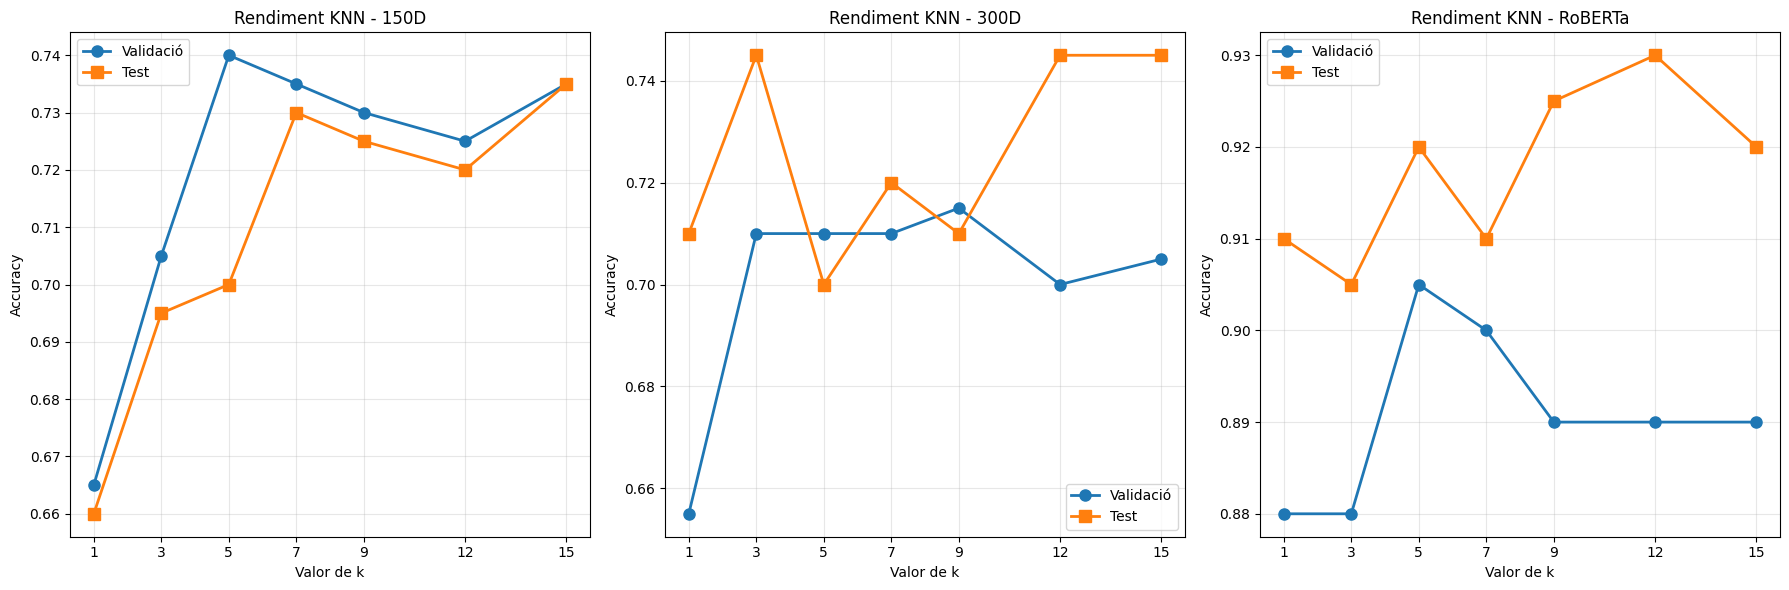


COMPARACIÓ FINAL


,Dataset,Millor k,Accuracy Validació,Accuracy Test
0,150D,5,0.740,0.700
1,300D,9,0.715,0.710
2,RoBERTa,5,0.905,0.920


In [32]:
# Executar KNN amb les tres versions diferents de dades TECLA

# Primer, definir les variables de dades per a les tres versions
datasets = {
    '150D': {
        'X_train': X_train_tecla150,
        'X_val': X_val_tecla150, 
        'X_test': X_test_tecla150,
        'y_train': y_train_tecla150,
        'y_val': y_val_tecla150,
        'y_test': y_test_tecla150
    },
    '300D': {
        'X_train': X_train_tecla300,
        'X_val': X_val_tecla300,
        'X_test': X_test_tecla300,
        'y_train': y_train_tecla300,
        'y_val': y_val_tecla300,
        'y_test': y_test_tecla300
    },
    'RoBERTa': {
        'X_train': X_train_roberta,
        'X_val': X_val_roberta,
        'X_test': X_test_roberta,
        'y_train': y_train_labels_roberta,
        'y_val': y_val_labels_roberta,
        'y_test': y_test_labels_roberta
    }
}

# Convertir etiquetes RoBERTa a índexs si són strings
if isinstance(datasets['RoBERTa']['y_train'][0], str):
    datasets['RoBERTa']['y_train'] = np.array([label_to_idx[label] for label in datasets['RoBERTa']['y_train']])
    datasets['RoBERTa']['y_val'] = np.array([label_to_idx[label] for label in datasets['RoBERTa']['y_val']])
    datasets['RoBERTa']['y_test'] = np.array([label_to_idx[label] for label in datasets['RoBERTa']['y_test']])

# Provar diferents valors de k per a cada dataset
k_values = [1,3,5, 7,9,12, 15]
all_knn_results = {}

for dataset_name, data in datasets.items():
    print(f"\n{'='*50}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*50}")
    
    knn_results = {}
    
    for k in k_values:
        print(f"\nEntrenant KNN amb k={k} per {dataset_name}...")
        
        # Crear model KNN
        knn_model = KNeighborsClassifier(n_neighbors=k, metric='cosine')
        
        # Entrenar amb dades corresponents
        knn_model.fit(data['X_train'], data['y_train'])
        
        # Prediccions
        y_pred_val = knn_model.predict(data['X_val'])
        y_pred_test = knn_model.predict(data['X_test'])
        
        # Avaluació
        val_accuracy = accuracy_score(data['y_val'], y_pred_val)
        test_accuracy = accuracy_score(data['y_test'], y_pred_test)
        
        knn_results[k] = {
            'model': knn_model,
            'val_accuracy': val_accuracy,
            'test_accuracy': test_accuracy,
            'val_predictions': y_pred_val,
            'test_predictions': y_pred_test
        }
        
        print(f"k={k} - Validació: {val_accuracy:.3f}, Test: {test_accuracy:.3f}")
    
    all_knn_results[dataset_name] = knn_results

# Trobar el millor model per cada dataset
print(f"\n{'='*60}")
print("RESUM DE RESULTATS KNN")
print(f"{'='*60}")

best_models = {}
for dataset_name, results in all_knn_results.items():
    best_k = max(results.keys(), key=lambda k: results[k]['val_accuracy'])
    best_models[dataset_name] = {
        'k': best_k,
        'val_accuracy': results[best_k]['val_accuracy'],
        'test_accuracy': results[best_k]['test_accuracy']
    }
    
    print(f"\n🏆 Millor model per {dataset_name}: k={best_k}")
    print(f"Accuracy de validació: {results[best_k]['val_accuracy']:.3f}")
    print(f"Accuracy de test: {results[best_k]['test_accuracy']:.3f}")

# Comparació visual dels resultats
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (dataset_name, results) in enumerate(all_knn_results.items()):
    k_vals = list(results.keys())
    val_accs = [results[k]['val_accuracy'] for k in k_vals]
    test_accs = [results[k]['test_accuracy'] for k in k_vals]
    
    axes[idx].plot(k_vals, val_accs, 'o-', label='Validació', linewidth=2, markersize=8)
    axes[idx].plot(k_vals, test_accs, 's-', label='Test', linewidth=2, markersize=8)
    axes[idx].set_xlabel('Valor de k')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'Rendiment KNN - {dataset_name}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xticks(k_vals)

plt.tight_layout()
plt.show()

# Taula comparativa final
comparison_data = []
for dataset_name, best_info in best_models.items():
    comparison_data.append({
        'Dataset': dataset_name,
        'Millor k': best_info['k'],
        'Accuracy Validació': f"{best_info['val_accuracy']:.3f}",
        'Accuracy Test': f"{best_info['test_accuracy']:.3f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print(f"\n{'='*40}")
print("COMPARACIÓ FINAL")
print(f"{'='*40}")
display(df_comparison)

Processant 5000 exemples amb RoBERTa embeddings...
Processat 0/5000 exemples
Processat 100/5000 exemples
Processat 200/5000 exemples
Processat 300/5000 exemples
Processat 400/5000 exemples
Processat 500/5000 exemples
Processat 600/5000 exemples
Processat 700/5000 exemples
Processat 800/5000 exemples
Processat 900/5000 exemples
Processat 1000/5000 exemples
Processat 1100/5000 exemples
Processat 1200/5000 exemples
Processat 1300/5000 exemples
Processat 1400/5000 exemples
Processat 1500/5000 exemples
Processat 1600/5000 exemples
Processat 1700/5000 exemples
Processat 1800/5000 exemples
Processat 1900/5000 exemples
Processat 2000/5000 exemples
Processat 2100/5000 exemples
Processat 2200/5000 exemples
Processat 2300/5000 exemples
Processat 2400/5000 exemples
Processat 2500/5000 exemples
Processat 2600/5000 exemples
Processat 2700/5000 exemples
Processat 2800/5000 exemples
Processat 2900/5000 exemples
Processat 3000/5000 exemples
Processat 3100/5000 exemples
Processat 3200/5000 exemples
Proc

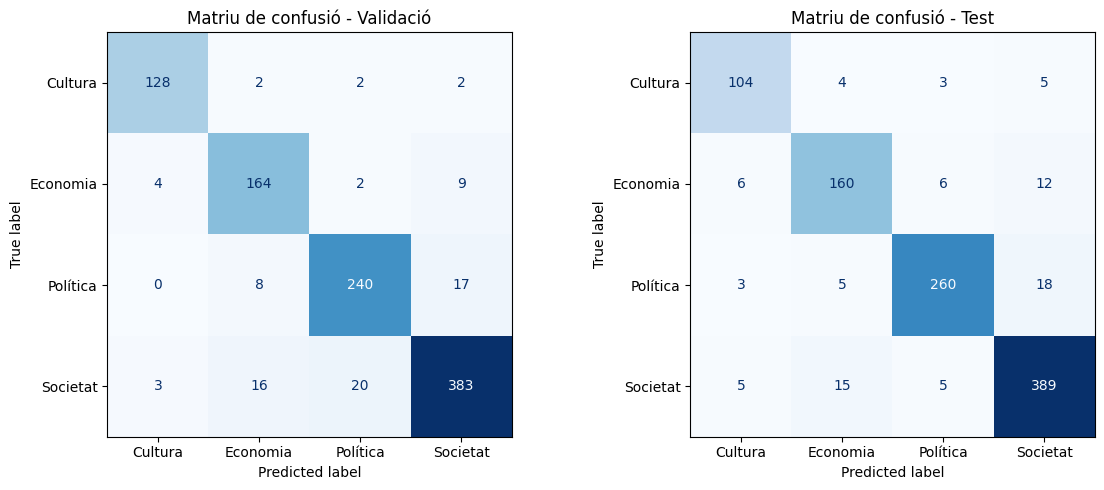

In [38]:
X_train_roberta, y_train_labels_roberta = preprocess_tecla_roberta(
    train, 5000
)
X_val_roberta, y_val_labels_roberta = preprocess_tecla_roberta(
    val, 1000
)
X_test_roberta, y_test_labels_roberta = preprocess_tecla_roberta(
    test, 1000
)
knn_model = KNeighborsClassifier(n_neighbors=3, metric='cosine')

# Entrenar amb dades corresponents
knn_model.fit(X_train_roberta, y_train_labels_roberta)

# Prediccions
y_pred_val = knn_model.predict(X_val_roberta)
y_pred_test = knn_model.predict(X_test_roberta)

# Avaluació
val_accuracy = accuracy_score(y_val_labels_roberta, y_pred_val)
test_accuracy = accuracy_score(y_test_labels_roberta, y_pred_test)

print(f"KNN (k=3) - Accuracy validació: {val_accuracy:.3f}, Accuracy test: {test_accuracy:.3f}")

# Gràfic de matriu de confusió per validació i test

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_val = confusion_matrix(y_val_labels_roberta, y_pred_val, labels=unique_labels)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=unique_labels)
disp_val.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Matriu de confusió - Validació")

cm_test = confusion_matrix(y_test_labels_roberta, y_pred_test, labels=unique_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=unique_labels)
disp_test.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Matriu de confusió - Test")

plt.tight_layout()
plt.show()